In [7]:
import csv
import numpy as np
import pandas as pd
from itertools import groupby

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt  
import warnings, datetime
import scipy.stats as ss


In [8]:
df=pd.read_csv('data/random_500.csv', sep=',',header=None)

In [9]:
# x value is the key, y value is the rank
X = np.array(df[0]).reshape(-1, 1)
y = df[1]

## Greedy Poisoning Regression CDF

In [10]:
def extract_non_occupied_keys(keyset):
    
    n = keyset.shape[0]
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    non_occupied_keys = []
    for i in range(lower_bound, upper_bound + 1):
        if i not in keyset:
            non_occupied_keys.append(i)
        
    return non_occupied_keys


def extract_seq(seq):
    return [
        [x for _, x in g]
        for k, g in groupby(
            enumerate(seq), 
            lambda i_x : i_x[0] - i_x[1]
        )
    ]   

def extract_endpoints(subsequences):
    endpoints = []
    for sequence in subsequences:
        if len(sequence) == 1:
            endpoints.append(sequence[0])
        else:
            endpoints.append(sequence[0])
            endpoints.append(sequence[len(sequence)-1])
            
    return endpoints

def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)

    non_occupied_keys = extract_non_occupied_keys(keyset)
    
    subsequences = extract_seq(non_occupied_keys)
    endpoints = extract_endpoints(subsequences)
    return np.array(endpoints)


def compute_rank_for_endpoints(endpoints):
    list_rank = []
    
    for endpoint in endpoints:
        rank_X = X.copy()
        rank_X = np.append(rank_X, endpoint)
        rank = list(ss.rankdata(rank_X))
        #print(rank_X)
        list_rank.append(int(rank[len(rank)-1]))
    
    return list_rank
    

In [69]:
import operator
from statistics import mean


S = None
T = None

delta_S = {}
M_k = {}
M_k_square = {}

M_R = {}
M_R_square = {}
M_KR = {}

L = {}

def reset_values():
    delta_S = {}
    M_k = {}
    M_k_square = {}
    M_R = {}
    M_R_square = {}
    M_KR = {}
    L = {}



def calculate_initial_effects(i, S, T):
    
    keyset = np.array(X.copy())
    keyset = np.append(keyset, S[i])
    M_k[i] = mean(keyset)
    
    rankset = y.copy()
    rankset = np.append(rankset, T[i])
    M_R[i] = mean(rankset)
    
    M_k_square[i] = np.mean(keyset**2)
    
    M_R_square[i] = np.mean(rankset**2)
    
    M_KR[i] = np.mean(keyset*rankset)
    
    nominator = (M_KR[i] - (M_k[i] * M_R[i]))**2
    denominator = M_k_square[i] - (M_k[i])**2
    L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

def calculate_effects(i, S, T):
        # Total number of elements
        n = df.shape[0]
        
        delta_S[i] = S[i+1] - S[i] 

        M_k[i] = M_k[i-1] + delta_S[i] / (n) 
        M_k_square[i] = M_k_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

        M_R[i] = (n + 2) / 2
        M_R_square[i] = ((n+2)*(2*n+3)) / 6
        M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

        nominator = (M_KR[i] - M_k[i]*M_R[i])**2
        denominator = M_k_square[i] - (M_k[i])**2
        L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2
    

def obtain_poisoning_keys(p):
    # Total number of elements
    n = df.shape[0]

    # Number of posoning keys p
    P = p * n
    poisoning_keys = set()

    for j in range(int(P)):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        endpoints = partition_non_occupied_keys(X, poisoning_keys)

        # Compute the rank that key S(i) would have if it was inserted in K union P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j)
        list_rank = compute_rank_for_endpoints(endpoints)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K union P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;
        reset_values()

        S = endpoints
        T = list_rank


        calculate_initial_effects(0, S, T)

        for i in range(1, len(endpoints)-1):
            calculate_effects(i, S, T)

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        #print(S[optimal_key_index])
        poisoning_keys.add(S[optimal_key_index])
        #print(L)
    
    return poisoning_keys

## Linear regression with non-poissoned keys

In [70]:
regressor_legitimate = LinearRegression()
regressor_legitimate.fit(X, y) 

y_pred = regressor_legitimate.predict(X)

In [71]:
print("------------------")
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  
mse_legitimate = metrics.mean_squared_error(y, y_pred)

------------------
Mean Squared Error: 14.705531571425096


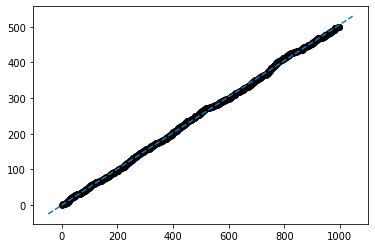

In [72]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Plot outputs
plt.scatter(X, y,  color='black')
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_)
plt.show()

## Linear regression with poissoned keys

In [73]:
poisoning_keys = obtain_poisoning_keys(p = 0.2)

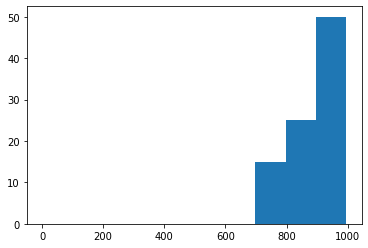

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_poisoning_keys(poisoning_keys):
    # we observe that poissoning keys are densly populated together
    plt.hist(poisoning_keys, bins = 10, range=[0, df[0][len(df)-1]])
    plt.show()

plot_poisoning_keys(poisoning_keys)

In [75]:
X_poissoned = np.append(X, list(poisoning_keys))
y_poissoned = ss.rankdata(X_poissoned)

In [76]:
X_poissoned = X_poissoned.reshape(-1,1)
regressor_poissoned = LinearRegression()
regressor_poissoned.fit(X_poissoned, y_poissoned)  

y_poissoned_pred = regressor_poissoned.predict(X_poissoned)

In [77]:
print("------------------")
print('Mean Squared Error:', metrics.mean_squared_error(y_poissoned, y_poissoned_pred))  
mse_poissoned = metrics.mean_squared_error(y_poissoned, y_poissoned_pred)

------------------
Mean Squared Error: 313.3296896963877


In [78]:
ratio_loss =  mse_poissoned / mse_legitimate

In [79]:
print(ratio_loss)

21.30692713653623


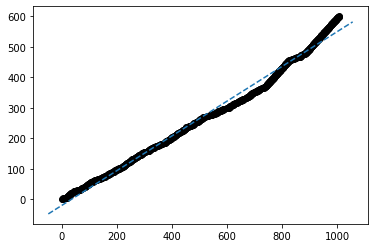

In [80]:
# Plot outputs
plt.scatter(X_poissoned, y_poissoned,  color='black')
abline(regressor_poissoned.coef_, regressor_poissoned.intercept_)
plt.show()

## Experiments

In [85]:
poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

ratio_losses = []

for percentage in poisoning_percentages:
    poisoning_keys = obtain_poisoning_keys(p = percentage)
    
    #plot_poisoning_keys(poisoning_keys)
    
    X_poissoned = np.append(X, list(poisoning_keys))
    y_poissoned = ss.rankdata(X_poissoned)
    
    X_poissoned = X_poissoned.reshape(-1,1)
    regressor_poissoned = LinearRegression()
    regressor_poissoned.fit(X_poissoned, y_poissoned)  

    y_poissoned_pred = regressor_poissoned.predict(X_poissoned)
    
    print("------------------")
    print('Mean Squared Error:', metrics.mean_squared_error(y_poissoned, y_poissoned_pred))  
    mse_poissoned = metrics.mean_squared_error(y_poissoned, y_poissoned_pred)
    ratio_loss =  mse_poissoned / mse_legitimate
    
    ratio_losses.append(ratio_loss)

plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
plt.show()

------------------
Mean Squared Error: 19.593873342240812
------------------
Mean Squared Error: 25.362443611616705
------------------
Mean Squared Error: 37.6545958726067
------------------
Mean Squared Error: 47.94161826733278
------------------
Mean Squared Error: 63.248337105765025
------------------
Mean Squared Error: 80.01137727248495
------------------
Mean Squared Error: 87.38468715028186
------------------
Mean Squared Error: 88.32178063766662
------------------
Mean Squared Error: 91.10630058552096
------------------
Mean Squared Error: 96.00220629846436
------------------
Mean Squared Error: 103.25630924928554
------------------
Mean Squared Error: 113.00168142069712
------------------
Mean Squared Error: 127.26158215550312
------------------
Mean Squared Error: 142.77838884597824
------------------
Mean Squared Error: 168.37143102210638


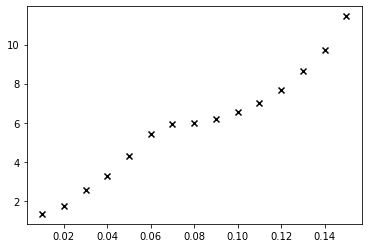